# Load Data

In [0]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn.metrics as metrics

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:


trDatOrg       = np.load('./drive/My Drive/flrnonflr-train-imgs224-0.8.npz')['arr_0']
trLblOrg       = np.load('./drive/My Drive/flrnonflr-train-labels224-0.8.npz')['arr_0']
tsDatOrg       = np.load('./drive/My Drive/flrnonflr-test-imgs224-0.8.npz')['arr_0']
tsLblOrg       = np.load('./drive/My Drive/flrnonflr-test-labels224-0.8.npz')['arr_0']

print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (4264, 224, 224, 3), (4264,), (1067, 224, 224, 3), (1067,)


Showing 847 index image, It is 0.0


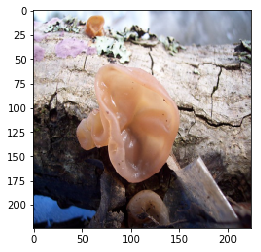

Showing 440 index image, It is 1.0


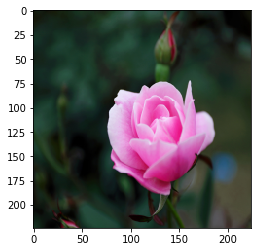

Showing 758 index image, It is 0.0


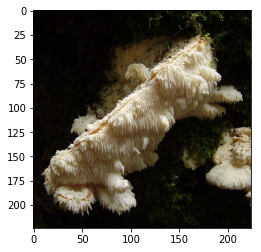

Showing 996 index image, It is 0.0


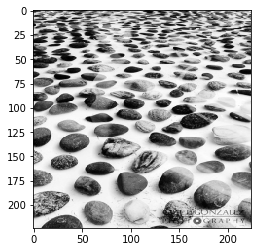

Showing 935 index image, It is 0.0


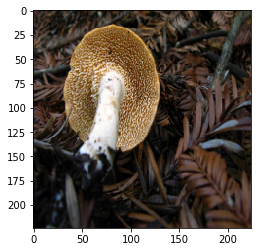

In [4]:
# Randomly show 5 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(5):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

In [0]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat       = trDatOrg.astype('float32')/255
tsDat       = tsDatOrg.astype('float32')/255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = 3

# # reshape the data to be [samples][width][height][channel]
# # This is required by Keras framework
# trDat       = trDat.reshape(trDat.shape[0], imgrows, imgclms, channel)
# tsDat       = tsDat.reshape(tsDat.shape[0], imgrows, imgclms, channel)

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg)
tsLbl       = to_categorical(tsLblOrg)
num_classes = tsLbl.shape[1]

# Define Model

In [6]:
# fix random seed for reproducibility
seed = 29
np.random.seed(seed)

modelname = 'FlowerPower_AlexNet'
optmz     = optimizers.RMSprop(lr=0.0001)

def lrSchedule(epoch):
    lr  = 1e-3
        
    if epoch > 110:
        lr  *= 1e-3
        
    elif epoch > 100:
        lr  *= 1e-2
        
    elif epoch > 80:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)
  
def createAlexNetModel():
    inputs = Input(shape=(imgrows, imgclms, channel))
    x = Conv2D(96, (11, 11), padding='same', strides=(4,4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3) ,strides=2)(x)
    x = Conv2D(256, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3) ,strides=2)(x)
    x = Conv2D(384, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(384, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3) ,strides=2)(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs],outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optmz,
                  metrics=['accuracy'])
    return model

model = createAlexNetModel()
modelGo = createAlexNetModel()

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________

In [0]:
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
#                                  monitor='val_acc', 
                                  monitor='val_loss',
                                  verbose=0, 
                                  save_best_only=True, 
#                                  mode='max')
                                  mode='min')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint, csv_logger, LRScheduler]
# callbacks_list  = [checkpoint, csv_logger]

In [8]:
# Fit the model
# This is where the training starts
# model.fit(trDat, 
#           trLbl, 
#           validation_data=(tsDat, tsLbl), 
#           epochs=120, 
#           batch_size=16,
#           callbacks=callbacks_list)

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=30,
                             horizontal_flip=True,
                             vertical_flip=False)

model.fit_generator(datagen.flow(trDat, trLbl, batch_size=32),
                    validation_data=(tsDat, tsLbl),
                    epochs=120, 
                    verbose=1,
                    steps_per_epoch=len(trDat)/32,
                    callbacks=callbacks_list)

Learning rate:  0.001
Epoch 1/120
134/133 [==============================] - 58s 432ms/step - loss: 15.8803 - acc: 0.5225 - val_loss: 6.5377 - val_acc: 0.5745
Learning rate:  0.001
Epoch 2/120
134/133 [==============================] - 53s 399ms/step - loss: 0.7372 - acc: 0.5675 - val_loss: 1.4715 - val_acc: 0.5745
Learning rate:  0.001
Epoch 3/120
134/133 [==============================] - 51s 384ms/step - loss: 0.6038 - acc: 0.7462 - val_loss: 2.1282 - val_acc: 0.5745
Learning rate:  0.001
Epoch 4/120
134/133 [==============================] - 55s 407ms/step - loss: 0.5251 - acc: 0.7859 - val_loss: 0.4384 - val_acc: 0.8257
Learning rate:  0.001
Epoch 5/120
134/133 [==============================] - 51s 381ms/step - loss: 0.5302 - acc: 0.7946 - val_loss: 0.4742 - val_acc: 0.7948
Learning rate:  0.001
Epoch 6/120
134/133 [==============================] - 51s 382ms/step - loss: 0.4895 - acc: 0.8089 - val_loss: 0.9040 - val_acc: 0.7891
Learning rate:  0.001
Epoch 7/120
134/133 [========

In [0]:
## Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do 
# final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [10]:
# Make classification on the test dataset
predicts    = modelGo.predict(tsDat)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)
labelname   = ['flower', 'non-flower']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 91.00%
              precision    recall  f1-score   support

      flower     0.8943    0.8943    0.8943       454
  non-flower     0.9217    0.9217    0.9217       613

    accuracy                         0.9100      1067
   macro avg     0.9080    0.9080    0.9080      1067
weighted avg     0.9100    0.9100    0.9100      1067

[[406  48]
 [ 48 565]]


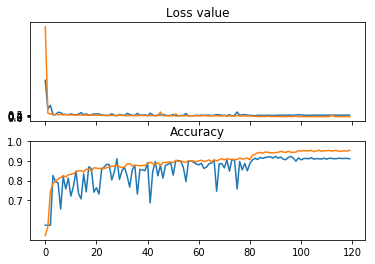

In [11]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0, 0.20, 0.30, 0.4, 0.5])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.7, 0.8, 0.9, 1.0])
plt.title('Accuracy',fontsize=12)
plt.show()

In [0]:
wrong_ans_index = []

for i in range(len(predout)):
    if predout[i] != testout[i]:
        wrong_ans_index.append(i)

In [0]:
wrong_ans_index = list(set(wrong_ans_index))

Showing 153 index image
Predicted as 0 but is actually 1


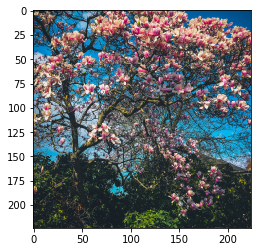

Showing 499 index image
Predicted as 0 but is actually 1


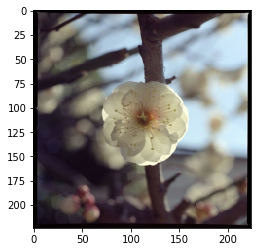

Showing 459 index image
Predicted as 0 but is actually 1


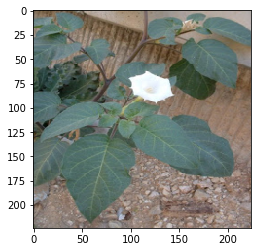

Showing 944 index image
Predicted as 1 but is actually 0


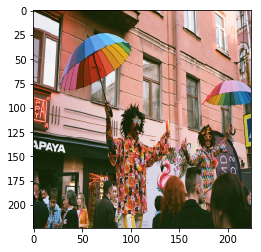

Showing 66 index image
Predicted as 0 but is actually 1


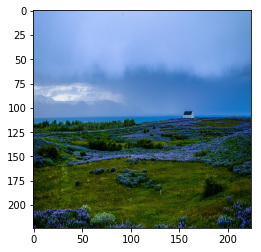

Showing 679 index image
Predicted as 1 but is actually 0


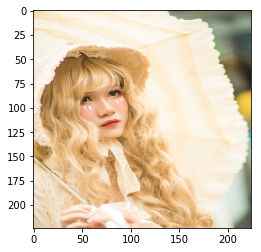

Showing 949 index image
Predicted as 1 but is actually 0


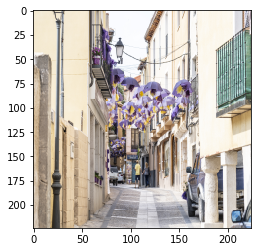

Showing 153 index image
Predicted as 0 but is actually 1


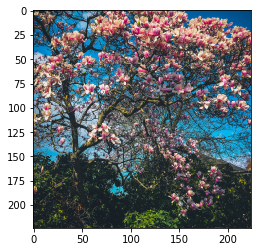

Showing 742 index image
Predicted as 1 but is actually 0


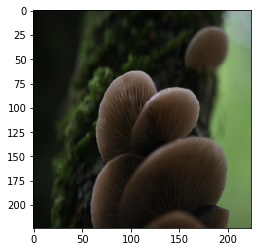

Showing 459 index image
Predicted as 0 but is actually 1


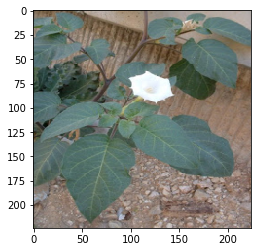

In [14]:
# Randomly show X examples of that was wrong

dataset = tsDatOrg #flowers #fungus #rocks

for index in range(10):
    index = wrong_ans_index[random.randint(0, len(wrong_ans_index)-1)]
    print("Showing %s index image" %(index))
    print("Predicted as %s but is actually %s" %(predout[index], testout[index]))
    imgplot = plt.imshow(data[index])
    plt.show()